<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [35]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

  Using cached prophet-1.0.1.tar.gz (65 kB)
  Using cached cmdstanpy-0.9.68-py3-none-any.whl (49 kB)
  Using cached ujson-5.2.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (45 kB)
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640686 sha256=44d574dfd6246db58bc4953d778ca1b78c764cf93445e9e7cb36e1ed8ae87a9b
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
     |████████████████████████████████| 6.6 MB 9.5 MB/s 
     |████████████████████

In [24]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf


from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA

## Задание 1 (1 балл). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекомендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



In [2]:
# скачаем данные
#
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=17qugOMRQkhfmGNGNMOkxMH_kbXtIZUPS' -O daily.csv 
# https://www.kaggle.com/datasets/bobnau/daily-website-visitors
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1SBrNhry91x4hgKuDDBKKv2zewDmlR_Qp' -O daily.csv 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_wZI3AKvm6_eoNlTxTPwjLY8sKFaDf7j' -O monthly.csv 

--2022-04-24 11:31:24--  https://docs.google.com/uc?export=download&id=1SBrNhry91x4hgKuDDBKKv2zewDmlR_Qp
Resolving docs.google.com (docs.google.com)... 142.251.5.100, 142.251.5.101, 142.251.5.113, ...
Connecting to docs.google.com (docs.google.com)|142.251.5.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d3tlukhjhman9jrk3bhnjf46bigh79dt/1650799875000/17587383742069257366/*/1SBrNhry91x4hgKuDDBKKv2zewDmlR_Qp?e=download [following]
--2022-04-24 11:31:25--  https://doc-00-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/d3tlukhjhman9jrk3bhnjf46bigh79dt/1650799875000/17587383742069257366/*/1SBrNhry91x4hgKuDDBKKv2zewDmlR_Qp?e=download
Resolving doc-00-6s-docs.googleusercontent.com (doc-00-6s-docs.googleusercontent.com)... 66.102.1.132, 2a00:1450:400c:c06::84
Connecting to doc-00-6s-docs.googleusercontent.com (doc-00-6s-docs.googleuser

In [3]:
def process_montly_dataset(dataset):
    dataset.drop(['D-J-F','M-A-M','J-J-A','S-O-N', 'metANN'], axis=1, inplace=True)
    for i in dataset.columns:
        dataset[i] = dataset[i].replace(999.90, np.NaN)
        dataset[i] = dataset[i].fillna(dataset[i].rolling(12,1).mean())

    dataset.columns = ['year', ] + [f'{i:02d}' for i in range(1, 13)]
    dataset = pd.melt(
        dataset,
        id_vars=['year'],
        value_vars=dataset.columns[1:],
        var_name='month',
        value_name='value'
    )
    dataset['date'] = pd.to_datetime(dataset['year'].astype(str) + '-' + dataset['month'].astype(str), format='%Y-%m')
    dataset.drop(['year', 'month'], axis=1, inplace=True)
    dataset.sort_values(by='date',inplace=True)
    dataset = dataset[dataset.date > datetime.strptime('1946-01-01', '%Y-%m-%d')]
    dataset = dataset.set_index('date')
    dataset.index = dataset.index + pd.tseries.offsets.MonthEnd(1)
    dataset.index = pd.PeriodIndex(dataset.index.values, freq='M')
    
    return dataset.value

def process_daily_dataset(dataset):
    dataset['date'] = pd.to_datetime(dataset['Date'])
    dataset['value'] = dataset['Unique.Visits'].str.replace(',', '.').astype(float)
    dataset = dataset[['date', 'value']]
    dataset = dataset.sort_values(by='date')
    dataset = dataset[dataset.date > datetime.strptime('2018-01-01', '%Y-%m-%d')]
    dataset = dataset[dataset.date < datetime.strptime('2020-01-01', '%Y-%m-%d')]
    dataset = dataset.set_index('date')
    dataset.index = pd.PeriodIndex(dataset.index.values, freq="D")
    return dataset.value

In [4]:
# считаем файлы
ts1 = process_montly_dataset(pd.read_csv("monthly.csv"))
ts2 = process_daily_dataset(pd.read_csv("daily.csv"))

In [5]:
ts1_train, ts1_test = train_test_split(ts1, test_size=0.25, shuffle=False)
assert ts1_train.index.max() < ts1_test.index.min()

In [6]:
ts2_train, ts2_test = train_test_split(ts2, test_size=0.25, shuffle=False)
assert ts2_train.index.max() < ts2_test.index.min()

## Задание 2. Анализ временных рядов (1 балл).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики [автокорреляционных функций](https://www.machinelearningmastery.ru/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788/) для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

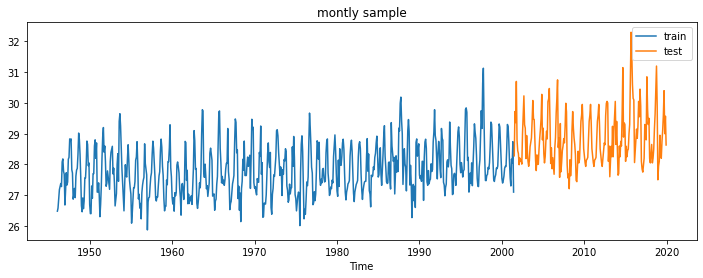

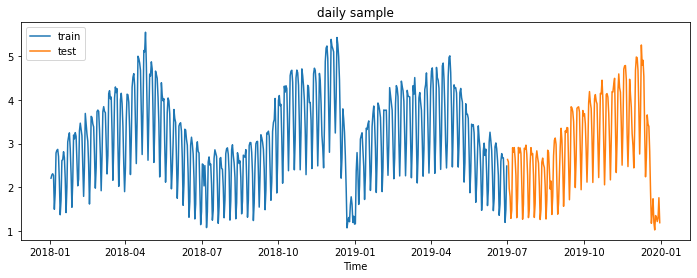

In [7]:
samples = {
    'montly' : [ts1_train, ts1_test],
    'daily' : [ts2_train, ts2_test]
}
def plot_ts(ts, label=''):
    x = ts.index.to_timestamp()
    plt.plot(x, ts.values, label=label)

for sample_name in samples.keys():
    train, test = samples[sample_name]
    # отрисуем временные ряды
    plt.figure(figsize=(12, 4))
    plt.title(sample_name + ' sample')
    plot_ts(train, label='train')
    plot_ts(test, label='test')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

### Анализ месячного ряда

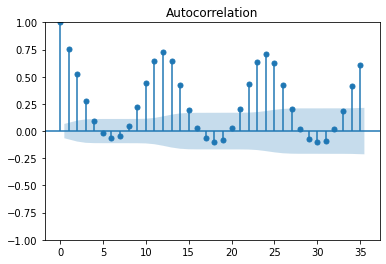

In [8]:
sm.graphics.tsa.plot_acf(ts1.values, lags=35)
plt.show()

**Вывод:** как и ожидалось – цикличность в 12 месяцев

Разобьём временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуем их наложенными

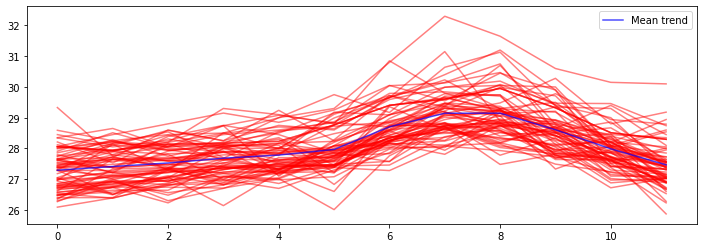

In [9]:
plt.figure(figsize=(12, 4))
stack = []
for i in range(len(ts1) // 12):
    left, right = i * 12, (i + 1) * 12
    series = ts1.values[left:right]
    plt.plot(np.arange(12), series, color='r', alpha=0.5)
    stack.append(series)
stack = np.array(stack)
mean_trend = stack.mean(axis=0)
plt.plot(np.arange(12), mean_trend, color='b', alpha=0.7, label='Mean trend')
plt.legend()
plt.show()


### Анализ дневного ряда

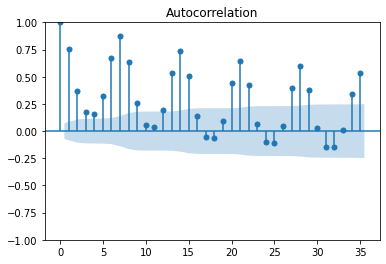

In [10]:
sm.graphics.tsa.plot_acf(ts2.values, lags=35)
plt.show()

**Вывод:** наблюдается цикличность в 7 дней. Это логично, так как посещение научного сайта зависит от дня недели

Разобьём временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуем их наложенными

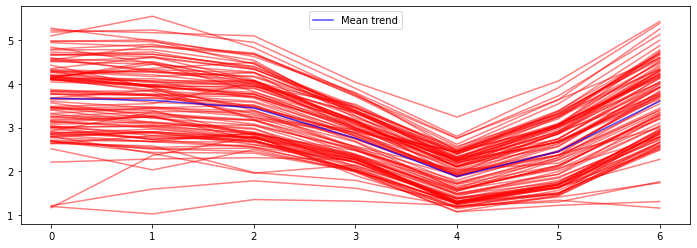

In [11]:
plt.figure(figsize=(12, 4))
stack = []
for i in range(len(ts1) // 7):
    if (i + 1) * 7 >= len(ts2):
        break
    left, right = i * 7, (i + 1) * 7
    series = ts2.values[left:right]
    plt.plot(np.arange(7), series, color='r', alpha=0.5)
    stack.append(series)
stack = np.array(stack)
mean_trend = stack.mean(axis=0)
plt.plot(np.arange(7), mean_trend, color='b', alpha=0.7, label='Mean trend')
plt.legend()
plt.show()


## Задание 3. Предсказание месячного временного ряда (4 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной ряд несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.

In [43]:
def MAE(predicted, actual):
    mae = np.mean(np.abs(predicted - actual))
    return mae

def compare_ts(train, test, predicted, title=""):
    plt.figure(figsize=(12, 4))
    plt.title(title)
    plot_ts(train, 'train')
    plot_ts(test, 'test')
    plot_ts(predicted, 'predicted')
    plt.legend()
    plt.show()
    print("MAE на тесте = {:.2f}".format(MAE(predicted, test)))

### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

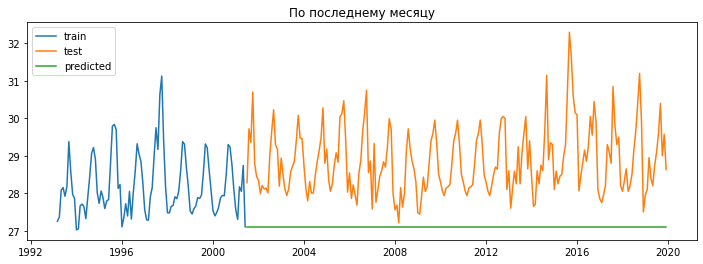

MAE на тесте = 1.75


In [44]:
forecaster = NaiveForecaster(strategy="last", sp=1)
forecaster.fit(ts1_train)
predicted = forecaster.predict(fh=np.arange(1, len(ts1_test) + 1))
compare_ts(ts1_train.iloc[-100:], ts1_test, predicted, "По последнему месяцу")

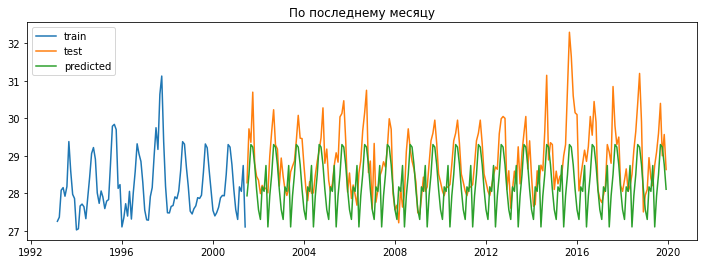

MAE на тесте = 0.75


In [45]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(ts1_train)
predicted = forecaster.predict(fh=np.arange(1, len(ts1_test) + 1))
compare_ts(ts1_train.iloc[-100:], ts1_test, predicted, "По последнему месяцу")

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

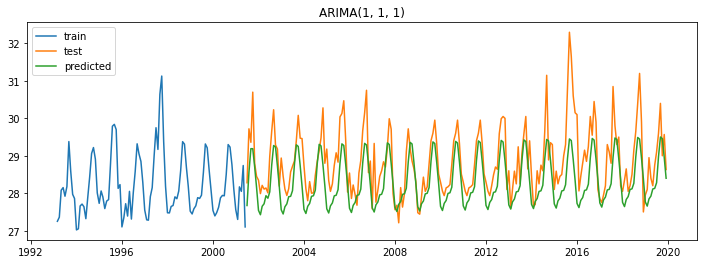

MAE на тесте = 0.59


In [49]:
forecaster = ARIMA(seasonal_order=(1, 1, 1, 12))
forecaster.fit(ts1_train)
predicted = forecaster.predict(fh=np.arange(1, len(ts1_test) + 1))
compare_ts(ts1_train.iloc[-100:], ts1_test, predicted, "ARIMA(1, 1, 1)")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


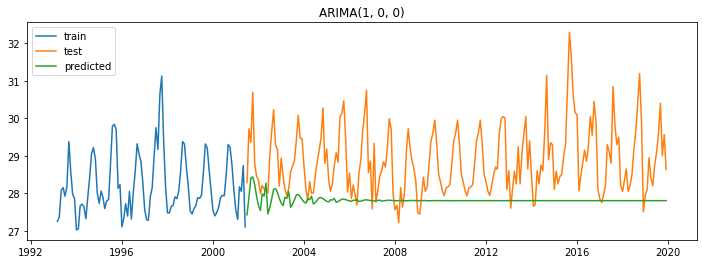

MAE на тесте = 1.07


In [50]:
forecaster = ARIMA(seasonal_order=(1, 0, 0, 12))
forecaster.fit(ts1_train)
predicted = forecaster.predict(fh=np.arange(1, len(ts1_test) + 1))
compare_ts(ts1_train.iloc[-100:], ts1_test, predicted, "ARIMA(1, 0, 0)")

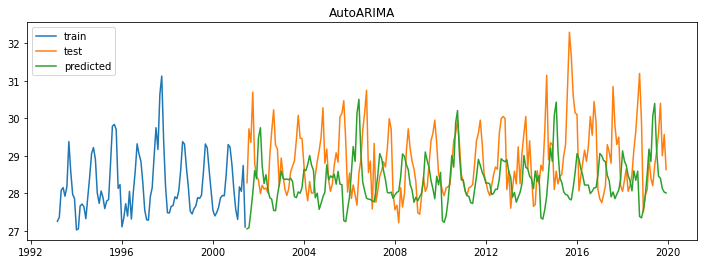

MAE на тесте = 0.93


In [51]:
forecaster = AutoARIMA(start_p=1, d=None, start_q=0, 
                       max_p=2, max_d=1, max_q=0, 
                       start_P=1, D=1, start_Q=0, 
                       max_P=1, max_D=1, max_Q=0, 
                       sp=52, suppress_warnings=True, stepwise=False, n_jobs=-1)

# обучение модели
forecaster.fit(ts1_train)
predicted = forecaster.predict(fh=np.arange(1, len(ts1_test) + 1))
compare_ts(ts1_train.iloc[-100:], ts1_test, predicted, "AutoARIMA")

### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [ ]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

### ETS (1 балл).

Обучите из библиотеки `sktime` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

In [ ]:
# нарисуйте пресказания

## Задание 4. Предсказание дневного временного ряда (3 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (1 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [ ]:
from sktime.forecasting.naive import NaiveForecaster

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

### KTR из orbit (1 балл).



In [ ]:
from orbit.models.ktrlite import KTRLiteMAP

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

### Phophet (1 балл).



In [ ]:
from prophet import Prophet

# ваш код обучения моделей здесь

In [ ]:
# посчитайте метрики на test

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

In [ ]:
# нарисуйте пресказания

## Задание 5. Предсказание временного ряда моделями машинного обучения (1 балл).

Возьмите один из ваших рядов, сформируйте по нему матрицу объект-признак и целевой вектор.

Разбейте данные на train/test в той же пропорции, что разбивали в заданиях выше.

Обучите различные классические модели машинного обучения и оцените их качество (MAE). 

Какая из моделей справилась с задачей предсказания лучше всего?

In [ ]:
# обучите классические модели ML

## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытайте свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной моделью на тестовой выборке с помощью MAE. 

Комментарий: итоговый балл за домашнее задание ставится по формуле минимум(10, ваш суммарный балл за задания).

In [ ]:
# ваш код модели на STAN и её обучения здесь

In [ ]:
# посчитайте метрики на test

In [ ]:
# нарисуйте предсказания